### Linear Quadratic Model Predictive Control

In [131]:
import numpy as np
from scipy import sparse
import lqmpc

In [132]:
# junk

def z_to_y(z):
    return (np.log(z)+5.468)/61.4
def y_to_z(y):
    return np.exp(61.4*np.array(y)-5.468)

m = 2
o = 2
inv = np.linalg.inv
pinv = np.linalg.pinv
I = np.eye(4)

A = np.array([[1, -6.66e-13, -2.03e-9, -4.14e-6],                               # State dynamics matrix
              [9.83e-4, 1, -4.09e-8, -8.32e-5],
              [4.83e-7, 9.83e-4, 1, -5.34e-4],
              [1.58e-10, 4.83e-7, 9.83e-4, .9994]])
B = np.array([[9.83e-4, 4.83e-7, 1.58e-10, 3.89e-14]]).T                        # Input to state matrix
B_ = np.array([[1e-5, 1e-5, 1e-10, 1e-14]]).T
if m == 2:
    B = np.hstack([B, -B])
if m == 3:
    B = np.hstack([B, -B, B_])
C = np.array([[-.0096, .0135, .005, -.0095]]) 
if o == 2:
    C = np.vstack([C, 0*C])
if o == 3:
    C = np.vstack([C, 2*C, 3*C])

Q = C.T@C*1e0
R = sparse.eye(m)*1e-6 
S = 0*sparse.eye(m)*1e-5
umin = np.array([0])                                                            
umax = np.array([10])

if m == 2:
    umin = np.array([0,0])                                                            
    umax = np.array([10,10])
if m == 3:
    umin = np.array([0,0,0])                                                            
    umax = np.array([10,10,10])

L = 120
u0 = np.zeros(m)                                                                
x0 = np.zeros(4)

t_step = 0.001

zr = 0.05*np.sin(np.linspace(0,2*np.pi,(L+25)*250)*8)+0.1
zr2 = 0.05*np.sin(np.linspace(0,2*np.pi,(L+25)*250)*4)+0.1
zr2 = 0.2*np.ones((L+25)*250)
#zr = np.hstack([1.5*zr[:int(len(zr)/4)],
#                0.5*zr[:int(len(zr)/4)],
#                1*zr[:int(len(zr)/4)],
#                4*zr[:int(len(zr)/4)+2]])

yr = z_to_y([zr])
if o == 2:
    #yr = np.vstack([yr, 2*yr])
    zr = np.vstack([[zr], [zr2]])
    yr = z_to_y(zr)
if o == 3:
    yr = np.vstack([yr, 2*yr, 3*yr])
#ur1 = inv(C@inv(I-A)@B)@yr
ur = pinv(C@inv(I-A)@B)@yr
xr = inv(I-A)@B@ur
print(xr[:,500])
print(C@xr[:,500])
print(y_to_z(C@xr[:,500]))
print(yr[:,500])
print(zr[:,500])


[ 66.95246915 429.56773502 482.48626012 790.81914249]
[0.05607017 0.        ]
[0.13195533 0.00421966]
[0.05607017 0.06284303]
[0.13195533 0.2       ]


Simulation Time: 0.5474650859832764 s 
Mean Step Time: 0.004562209049860637 
Output Error: 0.0006425938935083966


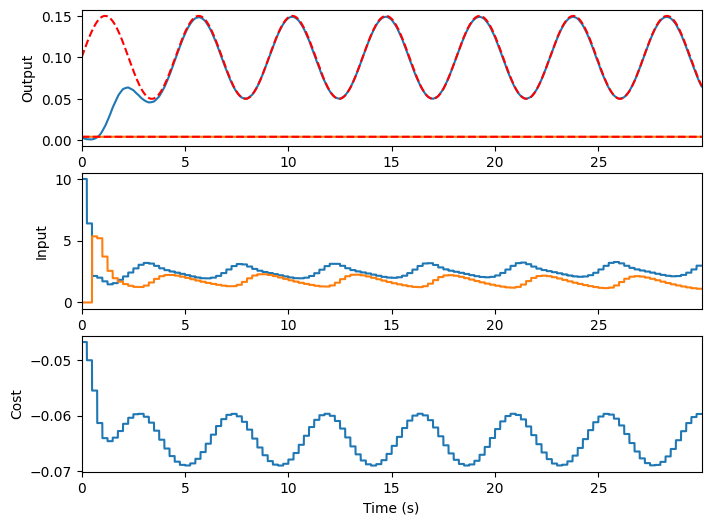

In [133]:
mpc = lqmpc.LQMPC(t_step,A,B,C)
mpc.set_control(Q=Q,R=R,S=S,N=25,M=20)
mpc.set_constraints(umin=umin,umax=umax)
mpc.simulate(0.25, x0, u0, xr, L)
mpc.plot(f=y_to_z)